Notebook to implement/experiment BatchRunner

In [1]:
import mesa
import random

from typing import Type, Callable
from collections import defaultdict

In [2]:
class BaseSchedulerByFilteredType(mesa.time.BaseScheduler):

    def __init__(self, model: mesa.Model) -> None:
        super().__init__(model)
        self.agents_by_type = defaultdict(dict)

    def add(self, agent: mesa.Agent) -> None:
        """
        Add an Agent object to the schedule

        Args:
            agent: An Agent to be added to the schedule.
        """
        super().add(agent)
        agent_class: type[mesa.Agent] = type(agent)
        self.agents_by_type[agent_class][agent.unique_id] = agent

    def get_type_count(
            self,
            type_class: Type[mesa.Agent],
            filter_func: Callable[[mesa.Agent], bool] = None,
    ) -> int:
        """
        Returns the current number of agents of certain type in the queue that satisfy the filter function.
        """
        count = 0
        for agent in self.agents_by_type[type_class].values():
            if filter_func is None or filter_func(agent):
                count += 1
        return count

In [3]:
class Patch(mesa.Agent):

    def __init__(self, unique_id, pos, model):
        """
        Creates a new patch of grass

        Args:
            fully_grown: (boolean) Whether the patch of grass is fully grown or not
        """
        super().__init__(unique_id, model)
        self.name = str()
        self.pcolor = str()
        self.pos = pos
        self.fitness: float = 0

        self.n_neighboring_altruists = 0  # N_A in paper
        self.sum_fitness_selfish_in_neighborhood = 0
        self.sum_fitness_altruists_in_neighborhood = 0
        self.sum_fitness_harshness_in_neighborhood = 0
        self.sum_total_fitness_in_neighborhood = 0
        self.weight_fitness_selfish_in_neighborhood = 0
        self.weight_fitness_altruists_in_neighborhood = 0
        self.weight_fitness_harshness_in_neighborhood = 0

    def n_neighboring_agents(self):
        # print("position " + str(self.pos))
        n_neighbor_selfish = 0
        n_neighbor_altruists = 0
        n_neighbor_voids = 0
        neighbor_iterator = self.model.grid.iter_neighbors(self.pos, moore=False, include_center=True, radius=1)
        for neighbor in neighbor_iterator:
            # print(str(neighbor.pos) + ":  " + str(neighbor.name))
            if neighbor.name == "selfish":
                n_neighbor_selfish += 1
            elif neighbor.name == "altruist":
                n_neighbor_altruists += 1
            if neighbor.name == "void":
                n_neighbor_voids += 1
        n_neigborhood_cells = n_neighbor_selfish + n_neighbor_altruists + n_neighbor_voids
        # print("n_neigborhood_cells")
        # print(n_neigborhood_cells)

        return n_neighbor_selfish, n_neighbor_altruists, n_neighbor_voids, n_neigborhood_cells

    def calculate_fitness(self):
        self.n_neighboring_altruists = self.n_neighboring_agents()[1]  # N_A in paper
        n_neighbor_cells = self.n_neighboring_agents()[3]
        c = self.model.cost_of_altruism
        b = self.model.benefit_of_altruism
        fitness_void = self.model.harshness

        if self.name == "altruist":
            return 1 - c + b * self.n_neighboring_altruists / n_neighbor_cells
        elif self.name == "selfish":
            return 1 + b * (self.n_neighboring_altruists / n_neighbor_cells)
        elif self.name == "void":
            return fitness_void

    def step(self):
        n_selfish, n_altruists, n_voids, n_cells = self.n_neighboring_agents()
        self.fitness = self.calculate_fitness()
        self.model.datacollector.add_table_row(
            "Fitness", {
                "position": self.pos,
                "agent": self.name,
                "fitness": self.calculate_fitness(),
            }
        )

    # print("position " + str(self.pos) + " fitness " + str(self.name) + " = " + str(self.fitness()) + " N_A = " + str(
    #    n_altruists))
    # print("n_altruists")
    # print(n_altruists)
    # print("n_altruists/5")
    # print(float(n_altruists / n_cells))

In [4]:
class SelfishAltruist(mesa.Model):
    n_grid_cells_height = 40
    n_grid_cells_width = 40
    canvas_width = 400
    canvas_height = canvas_width * (n_grid_cells_height / n_grid_cells_width)
    altruistic_probability = 0.26
    selfish_probability = 0.26
    cost_of_altruism = 0.13
    benefit_of_altruism = 0.5
    disease = 0.0
    harshness = 0.0

    verbose_0 = True  # agent count
    verbose_1 = True  # agent_id activation move and eat
    verbose_2 = False  # agent death
    verbose_3 = False  # agent birth
    verbose_4 = False  # agent life span table
    verbose_5 = False  # agent average life span
    verbose_6 = False  # table agent count and cumulative energy per type
    verbose_7 = False  # Fitness values and tooltips in grid

    description = (
        "A model for simulating Selfish-Altruist behavior."
    )

    def __init__(
            self,
            n_grid_cells_width=n_grid_cells_width,
            n_grid_cells_height=n_grid_cells_height,
            altruistic_probability=altruistic_probability,
            selfish_probability=selfish_probability,
            cost_of_altruism=cost_of_altruism,
            benefit_of_altruism=benefit_of_altruism,
            disease=disease,
            harshness=harshness

    ):
        """
        Create a new Predator-Prey model with the given parameters.

        Args:
        """
        super().__init__()
        # Set parameters
        self.n_grid_cells_width = n_grid_cells_width
        self.n_grid_cells_height = n_grid_cells_height

        # fitness parameters
        self.harshness = harshness  # =/= to fitnes of a Void patch
        self.disease = disease

        # selfish-altruistic
        self.altruistic_probability = altruistic_probability
        self.selfish_probability = selfish_probability
        self.cost_of_altruism = cost_of_altruism
        self.benefit_of_altruism = benefit_of_altruism

        self.schedule = BaseSchedulerByFilteredType(self)

        self.grid = mesa.space.SingleGrid(self.n_grid_cells_width, self.n_grid_cells_height, torus=True)
        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Selfish": lambda m: m.schedule.get_type_count(Patch, lambda g: g.name == "selfish"),
                "Altruist": lambda m: m.schedule.get_type_count(Patch, lambda g: g.name == "altruist"),
                "Void": lambda m: m.schedule.get_type_count(Patch, lambda g: g.name == "void"),
            },
            tables={
                "Fitness": ["position", "agent", "fitness"],
                "Lottery": ["position", "current agent", "P[selfish]", "P[altruists]", "P[harshness]"],
            },
        )

        # initialize patches
        for _, x, y in self.grid.coord_iter():
            patch = Patch(self.next_id(), (x, y), self)
            self.grid.place_agent(patch, (x, y))
            self.schedule.add(patch)
            ptype = random.uniform(0, 1)
            if ptype < self.altruistic_probability:
                patch.benefit_out = 0
                patch.name = "altruist"
                patch.pcolor = "blue"
            elif ptype < self.altruistic_probability + self.selfish_probability:
                patch.benefit_out = 1
                patch.name = "selfish"
                patch.pcolor = "red"
            else:
                patch.benefit_out = 0
                patch.name = "void"
                patch.pcolor = "black"
                patch.altruism_benefit = 0

        self.running = True
        self.datacollector.collect(self)

    def step(self):

        self.schedule.step()  # Base schedule to find out fitness per cell/agent
        # collect fitness per cell/agent in Table
        self.datacollector.collect(self)
        # print("round 1: calculate fitness per cell:")
        # print(self.datacollector.get_table_dataframe("Fitness"))

        grid_iterator = self.grid.coord_iter()
        for agent, x, y in grid_iterator:
            position_agent = (x, y)
            # print(position_agent)
            # print(agent.name)
            # initialize al fitness values to zero
            agent.sum_fitness_selfish_in_neighborhood = 0
            agent.sum_fitness_altruists_in_neighborhood = 0
            agent.sum_fitness_harshness_in_neighborhood = 0
            agent.sum_total_fitness_in_neighborhood = 0
            agent.weight_fitness_selfish_in_neighborhood = 0
            agent.weight_fitness_altruists_in_neighborhood = 0
            agent.weight_fitness_harshness_in_neighborhood = 0
            neighbor_iterator = self.grid.iter_neighbors(position_agent, moore=False, include_center=True, radius=1)
            for neighbor in neighbor_iterator:
                if neighbor.name == "selfish":
                    agent.sum_fitness_selfish_in_neighborhood += neighbor.fitness
                elif neighbor.name == "altruist":
                    agent.sum_fitness_altruists_in_neighborhood += neighbor.fitness
                elif neighbor.name == "void":
                    agent.sum_fitness_harshness_in_neighborhood += neighbor.fitness
            agent.sum_total_fitness_in_neighborhood = agent.sum_fitness_selfish_in_neighborhood + \
                                                      agent.sum_fitness_altruists_in_neighborhood + \
                                                      agent.sum_fitness_harshness_in_neighborhood + self.disease
            if agent.sum_total_fitness_in_neighborhood > 0:
                # lottery weights
                agent.weight_fitness_selfish_in_neighborhood = agent.sum_fitness_selfish_in_neighborhood / \
                                                               agent.sum_total_fitness_in_neighborhood
                agent.weight_fitness_altruists_in_neighborhood = agent.sum_fitness_altruists_in_neighborhood / \
                                                                 agent.sum_total_fitness_in_neighborhood
                agent.weight_fitness_harshness_in_neighborhood = (
                                                                         agent.sum_fitness_harshness_in_neighborhood + self.disease) / \
                                                                 agent.sum_total_fitness_in_neighborhood
            else:
                agent.weight_fitness_selfish_in_neighborhood = 0
                agent.weight_fitness_altruists_in_neighborhood = 0
                agent.weight_fitness_harshness_in_neighborhood = 0

            self.datacollector.add_table_row(
                "Lottery", {
                    "position": position_agent,
                    "current agent": agent.name,
                    "P[selfish]": agent.weight_fitness_selfish_in_neighborhood,
                    "P[altruists]": agent.weight_fitness_altruists_in_neighborhood,
                    "P[harshness]": agent.weight_fitness_harshness_in_neighborhood,
                }
            )
        # print("round 2: calculate probabilities for next step")
        # print(self.datacollector.get_table_dataframe("Lottery"))
        grid_iterator = self.grid.coord_iter()
        for agent, x, y in grid_iterator:
            breed_chance = random.uniform(0, 1)
            if breed_chance < agent.weight_fitness_altruists_in_neighborhood:
                agent.benefit_out = 0  # todo: set into fitness equation
                agent.name = "altruist"
                agent.pcolor = "blue"
            elif breed_chance < agent.weight_fitness_altruists_in_neighborhood + agent.weight_fitness_selfish_in_neighborhood:
                agent.benefit_out = 1
                agent.name = "selfish"
                agent.pcolor = "red"
            else:
                agent.benefit_out = 0
                agent.name = "void"
                agent.pcolor = "black"
                agent.altruism_benefit = 0
                agent.fitness = self.harshness
                agent.weight_fitness_selfish_in_neighborhood = 0
                agent.weight_fitness_altruists_in_neighborhood = 0
                agent.weight_fitness_harshness_in_neighborhood = 0
                agent.sum_fitness_selfish_in_neighborhood = 0
                agent.sum_fitness_altruists_in_neighborhood = 0
                agent.sum_fitness_harshness_in_neighborhood = 0
        df_selfish = self.datacollector.get_model_vars_dataframe()["Selfish"]
        df_altruist = self.datacollector.get_model_vars_dataframe()["Altruist"]
        if df_selfish.iloc[-1] == 0 or df_altruist.iloc[-1] == 0:
            # https://stackoverflow.com/questions/34166030/obtaining-last-value-of-dataframe-column-without-index
            self.running = False


In [5]:
empty_model = SelfishAltruist()
empty_model.step()

In [6]:
# For a jupyter notebook add the following line:
%matplotlib inline

# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt

In [7]:
# This runs the model 100 times, each model executing 10 steps.
for j in range(100):
    # Run the model
    model = SelfishAltruist()
    for i in range(10):
        model.step()

In [8]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation="nearest")
plt.colorbar()

# If running from a text editor or IDE, remember you'll need the following:
# plt.show()

TypeError: object of type 'Patch' has no len()

### Batch Run

Like we mentioned above, you usually won't run a model only once, but multiple times, with fixed parameters to find the overall distributions the model generates, and with varying parameters to analyze how they drive the model's outputs and behaviors. Instead of needing to write nested for-loops for each model, Mesa provides a [`batch_run`](https://github.com/projectmesa/mesa/blob/main/mesa/batchrunner.py) function which automates it for you.

The batch runner also requires an additional variable `self.running` for the MoneyModel class. This variable enables conditional shut off of the model once a condition is met. In this example it will be set as True indefinitely.

We call `batch_run` with the following arguments:

* `model_cls`
<br/><br/>
The model class that is used for the batch run.
<br/><br/>

* `parameters`
<br/><br/>
A dictionary containing all the parameters of the model class and desired values to use for the batch run as key-value pairs. Each value can either be fixed ( e.g. `{"height": 10, "width": 10}`) or an iterable (e.g. `{"N": range(10, 500, 10)}`). `batch_run` will then generate all possible parameter combinations based on this dictionary and run the model `iterations` times for each combination.
<br/><br/>

* `number_processes`
<br/><br/>
If not specified, defaults to 1. Set it to `None` to use all the available processors.
<br/><br/>
Note: Multiprocessing does make debugging challenging. If your parameter sweeps are resulting in unexpected errors set `number_processes = 1`.
<br/><br/>

* `iterations`
<br/><br/>
The number of iterations to run each parameter combination for. Optional. If not specified, defaults to 1.<br/><br/>
* `data_collection_period`
<br/><br/>
The length of the period (number of steps) after which the model and agent reporters collect data. Optional. If not specified, defaults to -1, i.e. only at the end of each episode.
<br/><br/>

* `max_steps`
<br/><br/>
The maximum number of time steps after which the model halts. An episode does either end when `self.running` of the model class is set to `False` or when `model.schedule.steps == max_steps` is reached. Optional. If not specified, defaults to 1000.
<br/><br/>

* `display_progress`
<br/><br/>
Display the batch run progress. Optional. If not specified, defaults to `True`.

In the following example, we hold the height and width fixed, and vary the number of agents. We tell the batch runner to run 5 instantiations of the model with each number of agents, and to run each for 100 steps. 

We want to keep track of

1. the Gini coefficient value and
2. the individual agent's wealth development.

Since for the latter changes at each time step might be interesting, we set `data_collection_period = 1`.

Note: The total number of runs is 245 (= 49 different populations * 5 iterations per population). However, the resulting list of dictionaries will be of length 6186250 (= 250 average agents per population * 49 different populations * 5 iterations per population * 101 steps per iteration).

In [9]:
params = {"cost_of_altruism": 0.13, "benefit_of_altruism": 0.48}

results = mesa.batch_run(
    SelfishAltruist,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


To further analyze the return of the `batch_run` function, we convert the list of dictionaries to a Pandas DataFrame and print its keys.

In [10]:
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'cost_of_altruism', 'benefit_of_altruism',
       'Selfish', 'Altruist', 'Void'],
      dtype='object')


First, we want to take a closer look at how the Gini coefficient at the end of each episode changes as we increase the size of the population. For this, we filter our results to only contain the data of one agent (the Gini coefficient will be the same for the entire population at any time) at the 100th step of each episode and then scatter-plot the values for the Gini coefficient over the the number of agents. Notice there are five values for each population size since we set `iterations=5` when calling the batch run.

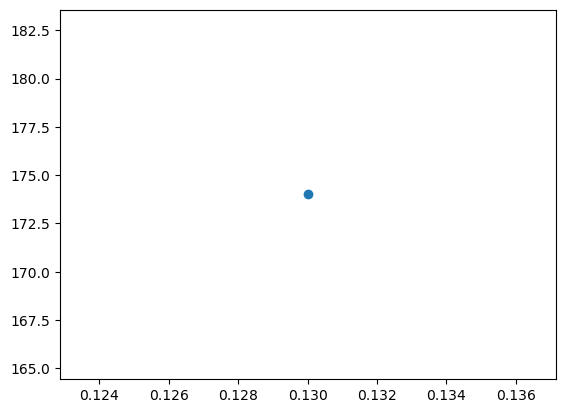

In [29]:
results_filtered = results_df[(results_df.RunId == 0) & (results_df.Step == 100)]
C_values = results_filtered.cost_of_altruism
gini_values = results_filtered.Altruist.values
plt.scatter(C_values, gini_values)

Second, we want to display the agent's wealth at each time step of one specific episode. To do this, we again filter our large data frame, this time with a fixed number of agents and only for a specific iteration of that population.
To print the results, we convert the filtered data frame to a string specifying the desired columns to print. 

Pandas has built-in functions to convert to a lot of different data formats. For example, to display as a table in a Jupyter Notebook, we can use the `to_html()` function which takes the same arguments as `to_string()` (see commented lines).

In [28]:
# First, we filter the results
one_episode_wealth = results_df[(results_df.N == 10) & (results_df.iteration == 2)]
# Then, print the columns of interest of the filtered data frame
print(
    one_episode_wealth.to_string(
        index=False, columns=["Step", "AgentID", "Wealth"], max_rows=25
    )
)
# For a prettier display we can also convert the data frame to html, uncomment to test in a Jupyter Notebook
# from IPython.display import display, HTML
# display(HTML(one_episode_wealth.to_html(index=False, columns=['Step', 'AgentID', 'Wealth'], max_rows=25)))

 Step  AgentID  Wealth
    0        0       1
    0        1       1
    0        2       1
    0        3       1
    0        4       1
    0        5       1
    0        6       1
    0        7       1
    0        8       1
    0        9       1
    1        0       2
    1        1       1
  ...      ...     ...
   99        8       0
   99        9       2
  100        0       0
  100        1       3
  100        2       1
  100        3       1
  100        4       0
  100        5       2
  100        6       1
  100        7       0
  100        8       0
  100        9       2


Lastly, we want to take a look at the development of the Gini coefficient over the course of one iteration. Filtering and printing looks almost the same as above, only this time we choose a different episode.

In [29]:
results_one_episode = results_df[
    (results_df.N == 10) & (results_df.iteration == 1) & (results_df.AgentID == 0)
]
print(results_one_episode.to_string(index=False, columns=["Step", "Gini"], max_rows=25))

 Step  Gini
    0  0.00
    1  0.00
    2  0.00
    3  0.00
    4  0.18
    5  0.18
    6  0.32
    7  0.32
    8  0.32
    9  0.32
   10  0.32
   11  0.32
  ...   ...
   89  0.54
   90  0.54
   91  0.54
   92  0.54
   93  0.54
   94  0.54
   95  0.54
   96  0.54
   97  0.54
   98  0.54
   99  0.54
  100  0.54


### Happy Modeling!

This document is a work in progress.  If you see any errors, exclusions or have any problems please contact [us](https://github.com/projectmesa/mesa/issues).

`virtual environment`: http://docs.python-guide.org/en/latest/dev/virtualenvs/

[Comer2014] Comer, Kenneth W. “Who Goes First? An Examination of the Impact of Activation on Outcome Behavior in AgentBased Models.” George Mason University, 2014. http://mars.gmu.edu/bitstream/handle/1920/9070/Comer_gmu_0883E_10539.pdf

[Dragulescu2002] Drăgulescu, Adrian A., and Victor M. Yakovenko. “Statistical Mechanics of Money, Income, and Wealth: A Short Survey.” arXiv Preprint Cond-mat/0211175, 2002. http://arxiv.org/abs/cond-mat/0211175.